In [1]:
import creation_tables as ct
import psycopg2 as p2
import pandas as pd
import folium as fl
import requests as rq
import json
import matplotlib.pyplot as plt

In [2]:
with open("custom.geo.json","r") as fjson:
    contours = json.loads(fjson.readline())

In [3]:
with ct.connexion() as conn:
    select_prop = """
                    SELECT  p.code,p.nom, 100*COALESCE(( 
                                        SELECT COUNT(*) 
                                        FROM enfant e
                                        INNER JOIN lettre l2 ON l2.id = e.id_lettre
                                        INNER JOIN pays p ON p.code = l2.code_pays
                                        WHERE l.code_pays = l2.code_pays
                                        AND e.age > 17
                                        GROUP BY p.code ),0)/COUNT(*) 
                    FROM enfant e
                    INNER JOIN lettre l ON l.id = e.id_lettre
                    INNER JOIN pays p ON p.code = l.code_pays
                    GROUP BY p.code, l.code_pays;
                    
                """
    valeurs = ct.rquery(conn,select_prop)
    dfval = pd.DataFrame.from_records(valeurs, columns=["iso","nom","part"])

In [4]:
m = fl.Map(location=[45, 5], zoom_start=2)

fl.Choropleth(
    geo_data=contours,
    name='choropleth',
    data=dfval,
    columns=['iso', 'part'],
    key_on='feature.properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Part d adultes (%)",
    smooth_factor=1,
    bins=7
).add_to(m)

fl.LayerControl().add_to(m)

m

In [5]:
def requete():
    """fonction execute ma requete sql pour nb lettre par pays"""

    # connection a la BDD
    conn = p2.connect(host = "localhost",
                                dbname = "santa_data",
                                user = "santa",
                                password = "claus",
                                port = 5432)

    # creation curseur
    cur = conn.cursor()

    cur.execute("""SELECT p.nom, COUNT(*) as nb
                        FROM lettre as l
                        INNER JOIN pays as p
                        ON l.code_pays = p.code
                        GROUP BY code;
                    ;""")


    pays_nbLettre = cur.fetchall()

    cur.close()

    conn.close()
    
    return pays_nbLettre

In [6]:
nbparpays = requete()
grospays = [p[0] for p in nbparpays if p[1]>100]
grosnb = [p[1] for p in nbparpays if p[1]>100]

petitpays = [p[0] for p in nbparpays if p[1]<=100]
petitnb = [p[1] for p in nbparpays if p[1]<=100]

In [7]:
total = 0
total += sum(grosnb)+ sum(petitnb)
nbsans = 1637 - total
if nbsans >0:
    if nbsans > 100:
        grospays.append("Non renseigné")
        grosnb.append(nbsans)
    else:
        petitpays.append("Non renseigné")
        petitnb.append(nbsans)

In [8]:
if len(petitpays)>0:
    grospays.append("Autres")
    grosnb.append(sum(petitnb))

grosprop = [round(x*100/1637,2) for x in grosnb]
petitprop = [round(x*100/sum(petitnb),2) for x in petitnb]

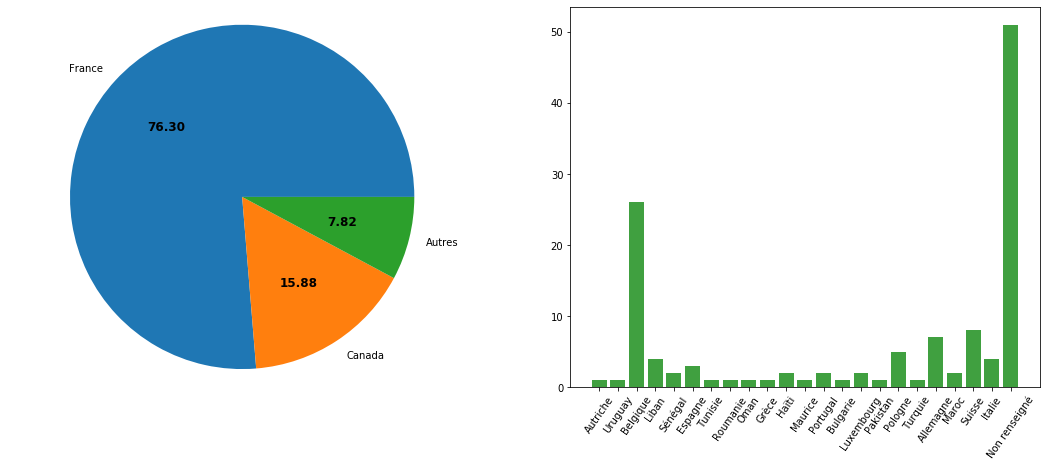

In [9]:
figureObject, (axesObject,axes2) = plt.subplots(ncols=2)


wedges, texts, autotexts = axesObject.pie(grosprop,

        labels = grospays,

        autopct = '%1.2f',

        startangle = 0,
        textprops=dict(color="k"))

plt.setp(autotexts, size=12, weight="bold")

axesObject.axis('equal')

axes2.bar(petitpays,petitnb,  facecolor='g', alpha=0.75)

fig = plt.gcf()
fig.set_size_inches(18.5, 7.0)
plt.xticks(rotation=55)

plt.show()